## Overview of A2C

## Problems with on-policy gradients methods

- high variance in training (compared to what?) 
    * compared to off-policy methods
    
- sample inefficiency (compared to what? )
    * compared to off-policy methods
    * a trajectory is sampled / used / then throw away
    
[Why policy gradient has high variance](https://www.quora.com/Why-does-the-policy-gradient-method-have-a-high-variance)


## Problems with off-policy methods
- bad samples are hoarded and resued
    * on-policy policy gradient methods are leaner (minimalist life-style)
    
- old samples come from old policy
    * to train the current policy, we need importance sampling to correct the distribution
    * not easy to do
    * so many off-policy methods don't do it

We can forget about policy and learn a q-function, but then how do we handle 
problems with continuous action space?

Conclusion: pick your poison. 


## A2C
How A2C solve those common problems of on-policy policy gradient methods

- High variance of policy gradient estimate
    * parallel env to sample many trajectories 
- Sample inefficiency
    * getting more samples

## Additional benefits

- More exploration of env
- Easy to parallel

## How to quantify stability? 

- Plot gradient, log probability of actions, advantages? 
    * really depends on the problem. For cartpole, it only takes a few steps to go from a good state to a bad state
    * so just become log probabiliy varies a lot does not necessary mean the training is not stable
    * For a finite episode problem like CartPole, the average reward for each epsisode seems to be a good measure of stability 
     
But it is not that straightforward to compute moving average of episode rewards, because we have parallel envs: env 1 might end vhile env 2 is still running. If we have only 1 enviroment, then this programming task is reduced
to keep tracking of moving average (which well-exercised leetcoder  should know how to do it in O(1) time and O(1) space)

## Stability

1. Why do we want stability?
* samples are generated from the policy
* bad policy -> bad samples -> bad policy


Factors affecting training stability
* number of parallel environments
* length of a trajectory
* gradient 


## Some debug work

In [1]:
!rm ckpt/debug/*
!rm log/debug/*

rm: cannot remove 'ckpt/debug/*': No such file or directory
rm: cannot remove 'log/debug/*': No such file or directory


In [76]:
!python test.py

In [ ]:
!tensorboard --logdir log/debug --bind_all

## Experiments: impact of number of parallel envs to stability
Intuition is more parallel envs increases stability

In [1]:
from rlalgos.A2C.a2c import A2C



In [12]:
from cartpole import a2c

h = {
    "n_iters": 1000,
    #"nenvs": 16, # to be changed
    "ckpt_interval": 100,
    "nsteps" : 30, # length of trajectory
    "entropy_coef" : 0.01, #1e-4, 
    "learning_rate": 1e-4,
    "p_coef": 1.0,
    "v_coef":1.0,
    "gamma": 0.99,
    "device": "cpu",
    "clip_grad_norm": False,
    "evaluate_critic": False
    #"ckpt_dir": 'ckpt/debug', # to be changed 
    #"log_dir": 'log/debug' # to be changed
}

for nenvs in range(10, 11):
    ckpt_dir = f'/home/ubuntu/tmp/a2c/ckpt/nenv-{nenvs}'
    log_dir = f'/home/ubuntu/tmp/logs/nenv-{nenvs}'
    h["nenvs"] = nenvs
    h["ckpt_dir"] = ckpt_dir
    h["log_dir"] = log_dir
    a2c(h)

In [2]:
def std(data, key):
    """compute std of data[key]"""
    arr = [x[1] for x in data[key]]
    return np.std(arr)

In [10]:
!ls /home/ubuntu/tmp/logs/nenv-10

events.out.tfevents.1622263668.ip-172-31-33-148.18644.0
events.out.tfevents.1622263699.ip-172-31-33-148.18644.1
events.out.tfevents.1622263725.ip-172-31-33-148.18644.2
events.out.tfevents.1622263729.ip-172-31-33-148.19365.0
events.out.tfevents.1622264302.ip-172-31-33-148.21236.0
events.out.tfevents.1622264792.ip-172-31-33-148.23083.0
events.out.tfevents.1622265261.ip-172-31-33-148.23867.0
events.out.tfevents.1622266987.ip-172-31-33-148.23867.2
experiment-data.pkl


In [13]:
# std of moving average for each experiment
import numpy as np
from utils import Logger

for nenv in range(10, 11):
    log_dir = f'/home/ubuntu/tmp/logs/nenv-{nenv}'
    logger = Logger(log_dir)
    data = logger.load()
    res = std(data, 'ma_rew')
    print(f"nenv: {nenv}, std of moving average reward : {res}")

nenv: 10, std of moving average reward : 44.241096958583334


In [101]:
# std of log probability of actions

for nenv in range(10, 16):
    log_dir = f'log/nenv-{nenv}'
    logger = Logger(log_dir)
    data = logger.load()
    res = std(data, 'log_pi_a')
    print(f"nenv: {nenv}, std of log probability of actions : {res}")

nenv: 10, std of log probability of actions : 0.03559497094184473
nenv: 11, std of log probability of actions : 0.03752836136908005
nenv: 12, std of log probability of actions : 0.03567263716485237
nenv: 13, std of log probability of actions : 0.03397460746003187
nenv: 14, std of log probability of actions : 0.03964350383657634
nenv: 15, std of log probability of actions : 0.03605159749922419


In [94]:
# std of loss

for nenv in range(10, 16):
    log_dir = f'log/nenv-{nenv}'
    logger = Logger(log_dir)
    data = logger.load()
    res = std(data, 'loss')
    print(f"nenv: {nenv}, std of loss: {res}")

nenv: 10, std of loss: 126.65723240246216
nenv: 11, std of loss: 126.60126408481901
nenv: 12, std of loss: 123.85701479739846
nenv: 13, std of loss: 126.65860444875733
nenv: 14, std of loss: 117.70909187803315
nenv: 15, std of loss: 125.34906857995779


## N && B: a few techniques to make training is stable

## Clip gradients or not

In [102]:


from cartpole import a2c

h = {
    "n_iters": 1000,
    "nenvs": 16, # to be changed
    "ckpt_interval": 10,
    "nsteps" : 30, # length of trajectory
    "entropy_coef" : 0.01, #1e-4, 
    "learning_rate": 1e-4,
    "p_coef": 1.0,
    "v_coef":1.0,
    "gamma": 0.99,
    "device": "cpu",
    #"clip_grad_norm": False,
    #"ckpt_dir": 'ckpt/debug', # to be changed 
    #"log_dir": 'log/debug' # to be changed
}

for opt in [True, False]:
    h['clip_grad_norm'] = opt
    h['ckpt_dir'] = f'ckpt/clip-grad-{opt}'
    h['log_dir'] = f'log/clip-grad-{opt}'
    #a2c(h)

### Std of moving average reward 

In [108]:
for opt in [True, False]:
    log_dir = f'log/clip-grad-{opt}'
    logger = Logger(log_dir)
    data = logger.load()
    res = std(data, 'ma_rew')
    print(f"clip gradient: {opt}, std of ma reward: {res}")

clip gradient: True, std of ma reward: 31.566684395435963
clip gradient: False, std of ma reward: 46.7627088209243


### Std of loss

In [109]:
for opt in [True, False]:
    log_dir = f'log/clip-grad-{opt}'
    logger = Logger(log_dir)
    data = logger.load()
    res = std(data, 'loss')
    print(f"clip gradient: {opt}, std of loss: {res}")

clip gradient: True, std of loss: 87.75686626245346
clip gradient: False, std of loss: 128.1899696474328


## Length of each trajectory
One trajectory (from parallel env) is used for one step policy and value iteration. Intuitively, longer trajectory helps the agent to learn the long term benefit of its action. 

* Longer trajectory makes training more stable
* Longer trajectory makes the agent learn faster
* Effect of a bad action can only surface after a few steps. 

In [111]:
h = {
    "n_iters": 1000,
    "nenvs": 16, # to be changed
    "ckpt_interval": 10,
    #"nsteps" : 30, # length of trajectory
    "entropy_coef" : 0.01, #1e-4, 
    "learning_rate": 1e-4,
    "p_coef": 1.0,
    "v_coef":1.0,
    "gamma": 0.99,
    "device": "cpu",
    "clip_grad_norm": True,
    #"ckpt_dir": 'ckpt/debug', # to be changed 
    #"log_dir": 'log/debug' # to be changed
}

for nsteps in range(5, 31):
    h["nsteps"] = nsteps
    h['ckpt_dir'] = f'ckpt/nsteps-{nsteps}'
    h['log_dir'] = f'log/nsteps-{nsteps}'
    #a2c(h)

In [120]:
# std of moving average reward

for nsteps in range(5, 31):
    log_dir = f'log/nsteps-{nsteps}'
    logger = Logger(log_dir)
    data = logger.load()
    res = std(data, 'ma_rew')
    print(f'trajectory length: {nsteps} | std of ma reward: {res}')

trajectory length: 5 | std of ma reward: 6.206312381559107
trajectory length: 6 | std of ma reward: 6.7941367262294765
trajectory length: 7 | std of ma reward: 11.88877426088386
trajectory length: 8 | std of ma reward: 12.65766606890771
trajectory length: 9 | std of ma reward: 12.049337735996671
trajectory length: 10 | std of ma reward: 14.811946064503886
trajectory length: 11 | std of ma reward: 16.305581726869427
trajectory length: 12 | std of ma reward: 20.12604333236117
trajectory length: 13 | std of ma reward: 15.68693050207474
trajectory length: 14 | std of ma reward: 22.111985664898228
trajectory length: 15 | std of ma reward: 19.667176656598706
trajectory length: 16 | std of ma reward: 22.924070967874297
trajectory length: 17 | std of ma reward: 24.94240039339594
trajectory length: 18 | std of ma reward: 25.832477444081537
trajectory length: 19 | std of ma reward: 27.05817743367623
trajectory length: 20 | std of ma reward: 26.653663867526497
trajectory length: 21 | std of ma re

# Oops! Pitfall

I guess I was implicitly thinking that higher reward and stability are positively correlated, because they are both desirable. 

Randomness
* randomness of the env
* randomess of action (sampled from prob)

This means
* Longer trajectory has "more randomness"
* => longer trajectory incurs a higher variance


In [115]:
# std of loss

for nsteps in range(5, 31):
    log_dir = f'log/nsteps-{nsteps}'
    logger = Logger(log_dir)
    data = logger.load()
    res = std(data, 'loss')
    print(f'trajectory length: {nsteps}', f'std of loss: {res}')

trajectory length: 5 std of loss: 15.95312442503258
trajectory length: 6 std of loss: 27.050928839895633
trajectory length: 7 std of loss: 25.569796520339374
trajectory length: 8 std of loss: 23.259475564346605
trajectory length: 9 std of loss: 27.114428326483672
trajectory length: 10 std of loss: 30.20247197956925
trajectory length: 11 std of loss: 38.41508256160848
trajectory length: 12 std of loss: 49.422973096028386
trajectory length: 13 std of loss: 42.26107678619629
trajectory length: 14 std of loss: 57.51039843141428
trajectory length: 15 std of loss: 51.04221888132379
trajectory length: 16 std of loss: 62.58077858350786
trajectory length: 17 std of loss: 66.96665101645331
trajectory length: 18 std of loss: 66.97736167957794
trajectory length: 19 std of loss: 76.10777375961906
trajectory length: 20 std of loss: 75.51169820482042
trajectory length: 21 std of loss: 67.49711880268305
trajectory length: 22 std of loss: 75.16493681600943
trajectory length: 23 std of loss: 74.21857834

In [121]:
# std of adv

for nsteps in range(5, 31):
    log_dir = f'log/nsteps-{nsteps}'
    logger = Logger(log_dir)
    data = logger.load()
    res = std(data, 'adv')
    print(f'trajectory length: {nsteps}', f'std of adv: {res}')

trajectory length: 5 std of adv: 1.2608268788123396
trajectory length: 6 std of adv: 1.5251485703363248
trajectory length: 7 std of adv: 1.4852788971378308
trajectory length: 8 std of adv: 1.5448067042383975
trajectory length: 9 std of adv: 1.8090801431709604
trajectory length: 10 std of adv: 1.7357480356143165
trajectory length: 11 std of adv: 2.0372059369785824
trajectory length: 12 std of adv: 2.1565931216087257
trajectory length: 13 std of adv: 2.2502100934415523
trajectory length: 14 std of adv: 2.2822920096137005
trajectory length: 15 std of adv: 2.357039214276123
trajectory length: 16 std of adv: 2.5615997374533688
trajectory length: 17 std of adv: 2.5606363888938106
trajectory length: 18 std of adv: 2.6407756721965017
trajectory length: 19 std of adv: 2.8086783766190107
trajectory length: 20 std of adv: 2.871514971747077
trajectory length: 21 std of adv: 2.795736732860649
trajectory length: 22 std of adv: 2.8621769379317827
trajectory length: 23 std of adv: 2.8838695771115392
t

In [117]:
# moving average of the reward
# at the end of the training

for nsteps in range(5, 31):
    log_dir = f'log/nsteps-{nsteps}'
    logger = Logger(log_dir)
    data = logger.load()
    res = data['ma_rew'][-1][1]
    print(f"trajectory length: {nsteps}, last ma reward {res}")

trajectory length: 5, last ma reward 32.723724365234375
trajectory length: 6, last ma reward 30.767850875854492
trajectory length: 7, last ma reward 70.91400146484375
trajectory length: 8, last ma reward 67.55679321289062
trajectory length: 9, last ma reward 76.67071533203125
trajectory length: 10, last ma reward 88.3529281616211
trajectory length: 11, last ma reward 56.044403076171875
trajectory length: 12, last ma reward 85.94941711425781
trajectory length: 13, last ma reward 80.94585418701172
trajectory length: 14, last ma reward 96.23628234863281
trajectory length: 15, last ma reward 84.31098175048828
trajectory length: 16, last ma reward 115.69566345214844
trajectory length: 17, last ma reward 115.28688049316406
trajectory length: 18, last ma reward 122.9968490600586
trajectory length: 19, last ma reward 104.73279571533203
trajectory length: 20, last ma reward 104.3149642944336
trajectory length: 21, last ma reward 123.93647766113281
trajectory length: 22, last ma reward 124.37062

Our intuition seems to be right here. 

## clip output of critic
If the output of critic has too much variance, then it defies the purpose of using a critic for actor-critic flavored algorithm.

## N && B: encourage exploration

* policy gradient methods are already exploratory, actions are sampled from action distribution rather than greedy
* want to avoid agent converge (over-confident) in the early stage
* want to make entropy of action distribution higher in the early stage 
* different random seed for each env
* start the env with some random actions


### Entropy
Entropy is baked into the loss

Let $\tau$ be a sample trajectory, $\alpha$ entropy coeff (temperature)

$\sum $ means $\sum_{s_i, a_i \in \tau}$

$$
Loss(\tau) = - \frac{1}{N} \sum\log \pi(a_i|s_i) A(a_i, s_i)  + \frac{1}{N}\sum|Q(a_i, s_i) - V(s_i) |^2 + \frac{1}{N}\alpha \sum \entropy(\pi(\cdot | s_i))
$$

Better exploration correlated with better rewards

In [129]:

h = {
    "n_iters": 1000,
    "nenvs": 16, # to be changed
    "ckpt_interval": 10,
    "nsteps" : 30, # length of trajectory
    #"entropy_coef" : 0, 
    "learning_rate": 1e-4,
    "p_coef": 1.0,
    "v_coef":1.0,
    "gamma": 0.99,
    "device": "cpu",
    "clip_grad_norm": True,
    #"ckpt_dir": 'ckpt/debug', # to be changed 
    #"log_dir": 'log/debug' # to be changed
}


for entropy_coef in [0, 0.01, 0.1]:
    ckpt_dir =f'ckpt/entropy-coef-{entropy_coef}'
    log_dir = f'log/entropy-coef-{entropy_coef}'
    h['entropy_coef'] = entropy_coef
    h['ckpt_dir'] = ckpt_dir
    h['log_dir'] = log_dir
    a2c(h)

In [135]:
# compare the rewards of experiements with
# different entropy coefficient
for ec in [0, 0.1, 0.01]:
    log_dir = f'log/entropy-coef-{ec}'
    data = Logger(log_dir).load()
    avg_reward = [x[1] for x in data['ma_rew']]
    print(f"entropy coef: {ec}, average reward {sum(avg_reward) / len(avg_reward)}")

entropy coef: 0, average reward 72.5942310142517
entropy coef: 0.1, average reward 64.95612062072755
entropy coef: 0.01, average reward 71.91440085220337


In [144]:
# average reward at latter stage of training
for ec in [0, 0.1, 0.01]:
    log_dir = f'log/entropy-coef-{ec}'
    data = Logger(log_dir).load()
    avg_reward = [x[1] for x in data['ma_rew']][-100:]
    print(f"entropy coef: {ec}, average reward {sum(avg_reward) / len(avg_reward)}")

entropy coef: 0, average reward 125.38384674072266
entropy coef: 0.1, average reward 113.5899333190918
entropy coef: 0.01, average reward 123.38497283935547


In [140]:
# linearly decay entropy coefficient


h = {
    "n_iters": 1000,
    "nenvs": 16, # to be changed
    "ckpt_interval": 10,
    "nsteps" : 30, # length of trajectory
    "entropy_coef" : 0.1, 
    "learning_rate": 1e-4,
    "p_coef": 1.0,
    "v_coef":1.0,
    "gamma": 0.99,
    "device": "cpu",
    "clip_grad_norm": True,
    #"ckpt_dir": 'ckpt/debug', # to be changed 
    #"log_dir": 'log/debug' # to be changed
}

def entropy_decay_fn(curr_coef, n_iter):
    return -(0.1/1000.0) * n_iter + 0.1

ckpt_dir = 'ckpt/entropy-decay'
log_dir = 'ckpt/entropy-decay'
h['ckpt_dir'] = ckpt_dir 
h['log_dir'] = log_dir

decay_fn = {"entropy_coef": entropy_decay_fn}

a2c(h, decay_fn)

In [143]:
og_dir = 'ckpt/entropy-decay'
data = Logger(log_dir).load()
avg_reward = [x[1] for x in data['ma_rew']]
print(f"with entropy decay, average reward {sum(avg_reward) / len(avg_reward)}")

with entropy decay, average reward 63.838873136520384


In [145]:
# later stage of training
og_dir = 'ckpt/entropy-decay'
data = Logger(log_dir).load()
avg_reward = [x[1] for x in data['ma_rew']][-100:]
print(f"with entropy decay, average reward {sum(avg_reward) / len(avg_reward)}")

with entropy decay, average reward 123.38497283935547


## N && B: check if critic is learning anything by viewing the estimate of initial state

For Cartpole, the initial state should have have high value (for a trained agent), so we can evalutate critic by 


In [166]:
h = {
    "n_iters": 1000,
    "nenvs": 16, # to be changed
    "ckpt_interval": 100,
    "nsteps" : 30, # length of trajectory
    "entropy_coef" : 0., 
    "learning_rate": 1e-4,
    "p_coef": 1.0,
    "v_coef":1.0,
    "gamma": 0.99,
    "device": "cpu",
    "clip_grad_norm": True,
    "evalute_critic": True
    #"ckpt_dir": 'ckpt/debug', # to be changed 
    #"log_dir": 'log/debug' # to be changed
}

ckpt_dir = 'ckpt/evaluate-critic'
log_dir = 'log/evaluate-critic'
h['ckpt_dir'] = ckpt_dir 
h['log_dir'] = log_dir

a2c(h)

Text(0, 0.5, 'estimate of initial state')

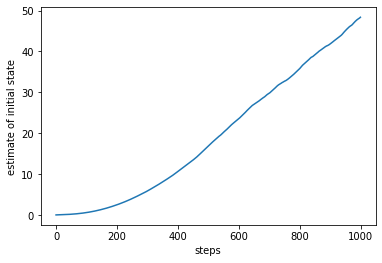

In [184]:
import matplotlib.pyplot as plt

log_dir = 'log/evaluate-critic'
init_state_estimate = Logger(log_dir).load()['init_state_estimate']
init_state_estimate = [x[1] for x in init_state_estimate]

plt.plot(init_state_estimate)
plt.xlabel('steps')
plt.ylabel('estimate of initial state')

## N && B: policy net and value net initialization

orthogonal initiazation

[provable benefit of orthogonal init](https://openreview.net/pdf?id=rkgqN1SYvr)

## N && B: separate backbone or 1 backbone
Just try it

## N && B: when something is wrong, look at what the policy is doing
The agent seems to not be able to 

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import gym

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    return


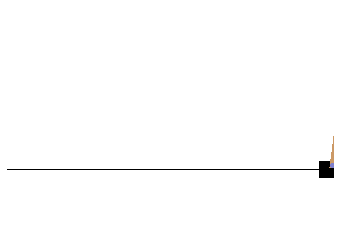

Episode finished after 194 timesteps


<Figure size 432x288 with 0 Axes>

In [12]:
from algo import Agent
from model import MLPSingleArch

h = {
    "n_iters": 1000,
    "nenvs": 16, # to be changed
    "ckpt_interval": 100,
    "nsteps" : 10, # length of trajectory
    "entropy_coef" : 0., 
    "learning_rate": 1e-4,
    "p_coef": 1.0,
    "v_coef":1.0,
    "gamma": 0.99,
    "device": "cpu",
    "clip_grad_norm": True,
    "evalute_critic": True
    #"ckpt_dir": 'ckpt/debug', # to be changed 
    #"log_dir": 'log/debug' # to be changed
}


env = gym.make('CartPole-v0').unwrapped
observation = env.reset()

agent = Agent(
    model = MLPSingleArch(
        input_dim = env.observation_space.shape[0],
        n_actions=env.action_space.n
    ), h=h)

agent.resume('ckpt/nsteps-7/ckpt-999.pt')
    
for t in range(1000):
    action = agent.take_action(observation, greedy=True)
    show_state(env, t)
    observation, reward, done, info = env.step(action[0])
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        plt.clf()
        break

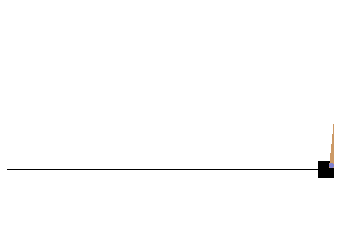

Episode finished after 229 timesteps


<Figure size 432x288 with 0 Axes>

In [14]:
env = gym.make('CartPole-v0').unwrapped
observation = env.reset()

agent = Agent(
    model = MLPSingleArch(
        input_dim = env.observation_space.shape[0],
        n_actions=env.action_space.n
    ), h=h)

agent.resume('ckpt/nsteps-29/ckpt-999.pt')
    
for t in range(1000):
    action = agent.take_action(observation, greedy=True)
    show_state(env, t)
    observation, reward, done, info = env.step(action[0])
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        plt.clf()
        break

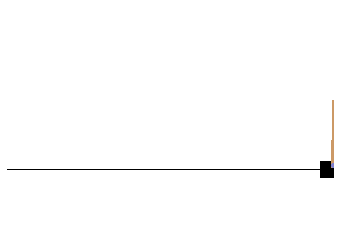

Episode finished after 1251 timesteps


<Figure size 432x288 with 0 Axes>

In [17]:
env = gym.make('CartPole-v0').unwrapped
observation = env.reset()

agent = Agent(
    model = MLPSingleArch(
        input_dim = env.observation_space.shape[0],
        n_actions=env.action_space.n
    ), h=h)

agent.resume('ckpt/nsteps-10/ckpt-999.pt')
    
for t in range(1500):
    action = agent.take_action(observation, greedy=True)
    show_state(env, t)
    observation, reward, done, info = env.step(action[0])
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        plt.clf()
        break
plt.clf()

## Inspect logs from training



In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

#logfile = '/home/ubuntu/tmp/logs/a2c/cartpole/0/progress.csv'

logfile = '/tmp/log/debug/progress.csv'
prog =pd.read_csv(logfile)#.dropna()

prog.head()

,Q,average_param,entropy,explained_var,init_est,iter/niters,ma_rew,policy_loss,value_loss,vpreds,vqdiff
0,9.242673,0.000214,0.692193,-0.009317,0.030310,10/10000,35.594524,6.307028,122.790306,0.123269,122.790325
1,8.737450,0.000334,0.692241,-0.028421,0.060961,20/10000,34.810470,5.880579,103.021220,0.239539,103.021221
2,9.020869,0.000547,0.692070,-0.040441,0.096698,30/10000,34.303734,5.987917,111.129020,0.349651,111.128998
3,8.634137,0.000856,0.690718,-0.053175,0.140809,40/10000,30.986355,5.625846,101.429090,0.519583,101.429106
4,8.194035,0.001236,0.688801,-0.068001,0.195117,50/10000,35.825058,5.248168,89.901000,0.664504,89.900987


Q


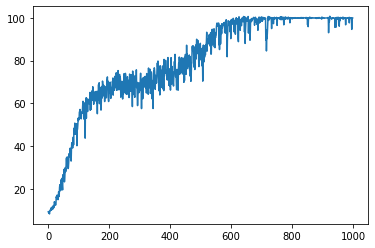


average_param


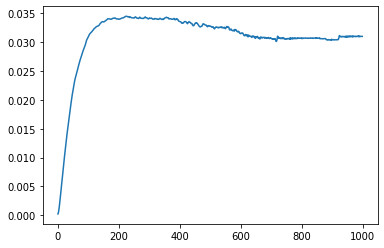


entropy


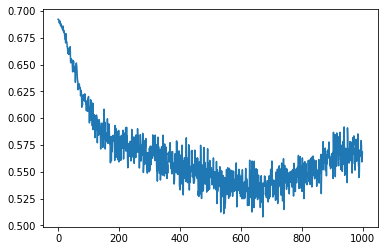


explained_var


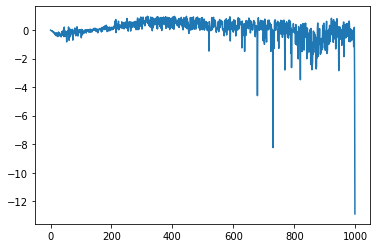


init_est


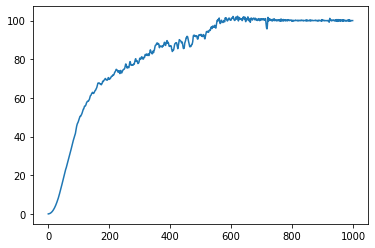


ma_rew


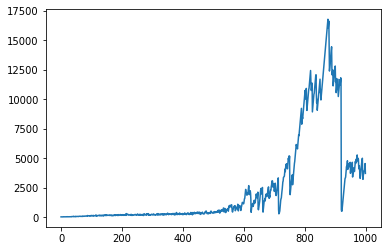


policy_loss


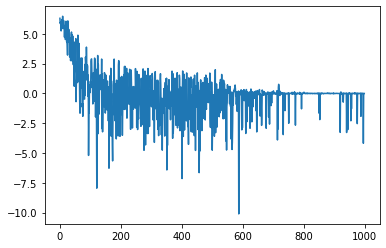


value_loss


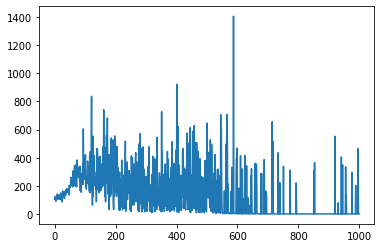


vpreds


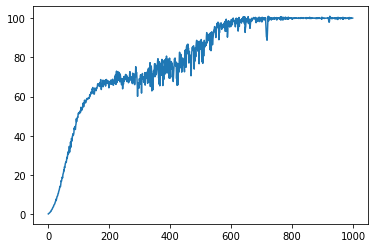


vqdiff


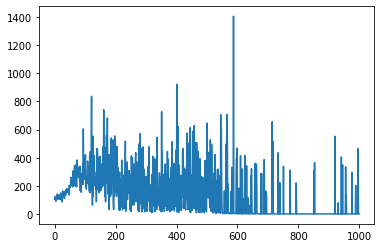

In [37]:
for c in prog.columns:
    if c == 'iter/niters': continue
    print(c)
    plt.plot(prog[c])
    plt.show()
    print()

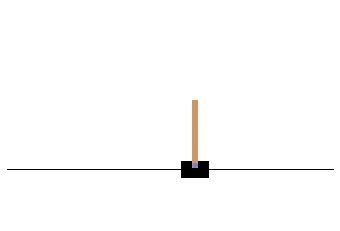

<Figure size 432x288 with 0 Axes>

In [38]:
# look at the agent's behavior
from algo import Agent
from model import MLPSingleArch

env = gym.make('CartPole-v0').unwrapped
observation = env.reset()

agent = Agent(
    model = MLPSingleArch(
        input_dim = env.observation_space.shape[0],
        n_actions=env.action_space.n
    ), h=h)

agent.resume('/tmp/ckpt/debug/0/ckpt-10000.pt')
    
for t in range(1500):
    action = agent.take_action(observation, greedy=True)
    show_state(env, t)
    observation, reward, done, info = env.step(action[0])
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        plt.clf()
        break
plt.clf()

## pass this trained agent to TrajectorySampler

Look at the behaviour of this agent over a trajectory. This is a way to debug the agent and the sampler. 

In [27]:
from algo import TrajectorySampler
from cartpole import make_env
from env_batch import ParallelEnvBatch

env = ParallelEnvBatch(make_env, nenvs=4)

sampler = TrajectorySampler(env, agent)

In [28]:
traj = sampler(nsteps=128)

In [30]:
type(traj[0])

algo.Experience

In [32]:
from algo import Experience

print(traj[0])

Experience(curr_state=array([[ 0.01894818,  0.191483  , -0.01738418, -0.31467869],
       [ 0.03610875,  0.1481333 ,  0.03010088, -0.20592525],
       [ 0.06122871,  0.63385992, -0.05451082, -0.96264672],
       [-0.04661395, -0.21629881, -0.00382745,  0.28914506]]), action=array([0, 1, 0, 1]), log_pi_a=tensor([-0.1832, -1.0053, -0.0175, -0.5034], grad_fn=<SqueezeBackward1>), entropy=tensor([0.4518, 0.6568, 0.0877, 0.6712], grad_fn=<NegBackward>), reward=array([1., 1., 1., 1.]), v=tensor([[ 99.9898],
        [ 99.9989],
        [ 99.9239],
        [100.0086]], grad_fn=<AddmmBackward>), nx_state=array([[ 0.02277784, -0.00338705, -0.02367776, -0.02752846],
       [ 0.03907141,  0.34281216,  0.02598237, -0.48896294],
       [ 0.0739059 ,  0.43951114, -0.07376376, -0.68757481],
       [-0.05093992, -0.02112249,  0.00195545, -0.00474254]]), done=array([False, False, False, False]))


In [35]:
# look at V
import numpy as np
for e in traj:
    print(np.squeeze(e.v.detach().numpy()))

[ 99.9898    99.99888   99.923874 100.00862 ]
[100.003105 100.007126  99.99039   99.985756]
[100.02351  99.9965   99.97923 100.00966]
[100.0276  100.03154  99.96517 100.00229]
[100.02647   99.99273   99.981735 100.00395 ]
[100.008026 100.02836  100.01522   99.99944 ]
[ 99.98625  99.99827 100.04485 100.00082]
[ 99.9865  100.02748 100.01106 100.00618]
[ 99.97867   99.982765 100.03573   99.99753 ]
[ 99.99036 100.0236  100.07972 100.00659]
[100.02171   99.996056 100.15893   99.96626 ]
[100.02403  100.0219   100.0655   100.009224]
[100.05827  99.96937 100.12089  99.96924]
[100.13513 100.01302 100.24238 100.01198]
[100.03287   99.957214 100.094124  99.99487 ]
[ 99.99898  99.99992 100.01121 100.01323]
[100.01084  99.99697  99.98622  99.97278]
[99.97756  99.988945 99.9822   99.974365]
[100.00803  99.99516 100.01866  99.98294]
[100.02343   99.981186  99.97269   99.978004]
[100.0017   99.99327 100.01931  99.99137]
[100.0218   99.97576  99.96002  99.98114]
[ 99.996605  99.99111  100.01263   99.99